# Vision Transformers
Les ViT sont une alternative aux CNNs pour les tâches de vision par ordinateur.
Ils appliquent directement l'architecture Transformer (utilisée en NLP) aux images, sans utiliser de convolutions.

## Principe de fonctionnement d'un ViT:
Contrairement aux CNNs qui utilisent des filtres de convolution pour extraire les caractéristiques locales, un ViT fonctionne en apprenant les relations globales entre les différentes parties de l'image grâce à l'auto-attention.
1. **Découpage de l'image en patchs:**

Plutôt que de traiter chaque pixel individuellement le ViT divise l'image en petits morceaux (patchs) de taille fixe.
Chaque patch est aplati en un vecteur traité comme un token (comme les mots dans un modèle Transformer pour texte)
2. **Encodage positionnel**
Pas de mécanisme intégré pour capturer la position spatiale des pixels pour les transformers (contrairement aux CNNs)
=> Encodage poitionnel des pixels pour garder leur ordre

3. **Passage dans un Transformer Standard**
L'ensemble des vecteurs de patchs + leur encodage positionnel est passé dans une architecture Transformer à plusieurs couches
* Multi-head self attention: Chaque patch intéragit avec les autres pour capturer des relations globales dans l'image.
* FFN: Un réseau dense affine les caractéristiques extraites.
* Layer Norm (Normalisation de couche) et DropOut pour stabiliser l'apprentissage.
# 4. Classification ou autre tâche
 Un token spécial **[CLS] Classification token** est ajouté aux patches.
 Après le passage dans le Transformer, ce token contient une représentation globale de l'image et est utilisé pour la classification.
 Pour une tâche de classification par exemple, la sortie: prédiction de la classe d'image.

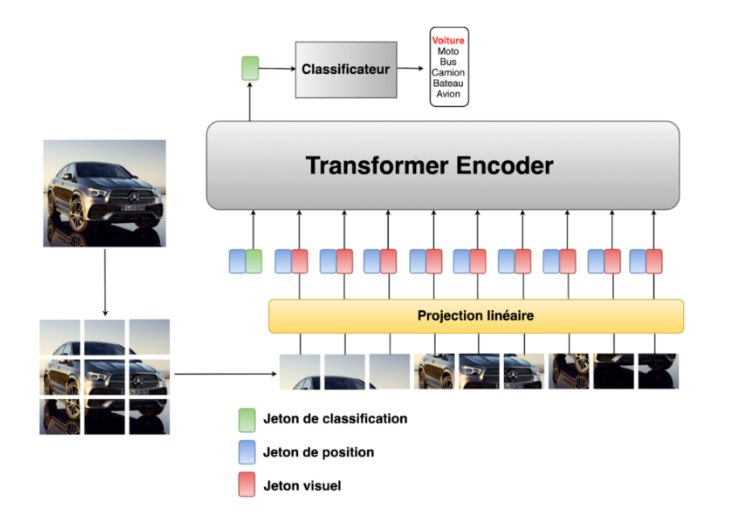

#Reconstruction d'images avec les ViT
L'idée est d'entrainer un ViT à prédire des parties manquantes d'une image après avoir masquer certains de ses patchs.

Le modèle apprend une représentation riche des images, facilitant diverses applications comme la restauration d'images, le remplissage intelligent ou l'apprentissage auto-supervisé.
 1. On masque une partie de l'image
 2. Le modèle apprend à reconstruire les zones manquantes en utilisant l'information des parties visibles.
 3. Une fonction de perte (MSE) guide l'apprentissage pour minimiser l'erreur entre l'image originale et prédite.

# Implémentation

# Installations requises

In [ ]:
#pip install torchmetrics


In [ ]:
#pip install pytorch-msssim

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import os
from torchvision.datasets import Flowers102
from torch.utils.data import random_split
from pytorch_msssim import ssim, ms_ssim
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure
from torchmetrics import MeanSquaredError


In [ ]:
# Définir les hyperparamètres
BATCH_SIZE = 32
NUM_EPOCHS = 6
LEARNING_RATE = 3e-4
IMAGE_SIZE = 128
PATCH_SIZE = 16
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
EMBED_DIM = 384
NUM_HEADS = 8
NUM_LAYERS = 6
MLP_RATIO = 4
MASK_RATIO = 0.3
TRAIN_SPLIT = 0.8
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Gestionnaire de masques pour les Vision Transformers


In [ ]:
# Cette classe gère la création de masques aléatoires et leur application aux patches d'image
class MaskGenerator:
    def __init__(self, image_size=128, patch_size=16, mask_ratio=0.5):
        """
        Initialise le générateur de masques avec les paramètres de base

        Args:
            image_size (int): Taille de l'image en pixels (supposée carrée)
            patch_size (int): Taille de chaque patch en pixels
            mask_ratio (float): Proportion de patches à masquer (entre 0 et 1)
        """
        self.image_size = image_size
        self.patch_size = patch_size
        # Calcul du nombre total de patches dans l'image
        self.num_patches = (image_size // patch_size) ** 2  # Par exemple: (128/16)² = 64 patches
        self.mask_ratio = mask_ratio
        # Taille de la grille de patches (nombre de patches par côté)
        self.grid_size = image_size // patch_size

    def random_mask(self, batch_size):
        """
        Génère un masque aléatoire pour chaque image du batch

        Args:
            batch_size (int): Nombre d'images dans le batch

        Returns:
            torch.Tensor: Masque booléen de forme (batch_size, num_patches)
                         True = patch visible, False = patch masqué
        """
        # Initialise un masque où tous les patches sont visibles
        mask = torch.ones(batch_size, self.num_patches, dtype=torch.bool)

        # Pour chaque image du batch, on masque aléatoirement des patches
        for i in range(batch_size):
            # Calcule le nombre de patches à masquer selon le ratio
            num_masked = int(self.num_patches * self.mask_ratio)
            # Sélectionne aléatoirement les indices des patches à masquer
            indices = torch.randperm(self.num_patches)[:num_masked]
            # Masque les patches sélectionnés (False = masqué)
            mask[i, indices] = False
        return mask

    def apply_mask(self, x):
        """
        Applique le masque aux patches d'image en remplaçant les patches masqués
        par un token de masque appris

        Args:
            x (torch.Tensor): Tensor de patches de forme (B, num_patches, embedding_dim)
                             où B est la taille du batch et embedding_dim est la dimension
                             de l'embedding de chaque patch

        Returns:
            tuple: (x_masked, mask)
                - x_masked (torch.Tensor): Patches avec masques appliqués (même forme que x)
                - mask (torch.Tensor): Masque booléen de forme (B, num_patches)
        """
        batch_size = x.shape[0]
        # Génère un masque aléatoire pour le batch
        mask = self.random_mask(batch_size)

        # Crée un token de masque appris
        # Ce token remplacera les patches masqués
        mask_token = nn.Parameter(torch.zeros(1, 1, x.shape[-1])).to(x.device)
        # Réplique le token de masque pour couvrir tous les patches du batch
        mask_tokens = mask_token.expand(batch_size, self.num_patches, -1)

        # Crée une copie des patches pour éviter de modifier l'original
        x_masked = x.clone()

        # Ajoute une dimension au masque pour le broadcasting
        mask = mask.unsqueeze(-1).to(x.device)
        # Remplace les patches masqués (où mask=False) par le token de masque
        # torch.where(condition, x, y) : renvoie x si condition=True, sinon y
        x_masked = torch.where(mask, x, mask_tokens)

        # Retourne les patches masqués et le masque (sans la dimension supplémentaire)
        return x_masked, mask.squeeze(-1)

### Composants de base du Transfomer

* PatchEmbedding : Divise l'image en patches et les projette dans un espace d'embedding de haute dimension, permettant au Transformer de traiter l'image comme une séquence.
* PositionalEmbedding : Ajoute des informations positionnelles aux patches pour préserver l'organisation spatiale de l'image.
* MultiHeadAttention : Implémente l'attention multi-têtes qui permet au modèle d'apprendre différents types de relations entre les patches.
* FeedForward : Un MLP à deux couches avec expansion dimensionnelle, appliqué à chaque position de la séquence indépendamment.
* TransformerBlock : Combine tous les composants avec normalisation et connexions résiduelles pour former un bloc Transformer complet.

In [ ]:
# Composants de base du Vision Transformer pour la reconstruction d'images masquées

class PatchEmbedding(nn.Module):
    """
    Convertit une image en une séquence de vecteurs de patches embeddings
    """
    def __init__(self, image_size=128, patch_size=16, in_channels=3, embed_dim=384):
        """
        Args:
            image_size (int): Taille de l'image d'entrée (supposée carrée)
            patch_size (int): Taille de chaque patch en pixels
            in_channels (int): Nombre de canaux d'entrée (3 pour RGB)
            embed_dim (int): Dimension de l'embedding de sortie
        """
        super().__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.embed_dim = embed_dim

        # Vérification que l'image peut être divisée en patches de taille égale
        assert image_size % patch_size == 0, f"L'image size {image_size} n'est pas divisible par patch size {patch_size}"

        # Projection séquentielle qui transforme l'image en patches puis en embeddings
        self.proj = nn.Sequential(
            # Réarrange l'image en patches : (B, C, H, W) -> (B, num_patches, patch_dim)
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
            # Projette chaque patch vers sa représentation d'embedding
            nn.Linear(patch_size * patch_size * in_channels, embed_dim)
        )

    def forward(self, x):
        """
        Forward pass qui convertit l'image en patches embeddings

        Args:
            x (torch.Tensor): Image d'entrée de forme (B, C, H, W)

        Returns:
            torch.Tensor: Patches embeddings de forme (B, num_patches, embed_dim)
        """
        # Vérification des dimensions d'entrée pour éviter les erreurs
        batch_size, channels, height, width = x.shape
        assert height == width == self.image_size, f"Les dimensions d'entrée {height}x{width} ne correspondent pas à image_size {self.image_size}"
        assert channels == self.in_channels, f"Le nombre de canaux {channels} ne correspond pas à in_channels {self.in_channels}"

        return self.proj(x)

class PositionalEmbedding(nn.Module):
    """
    Ajoute des embeddings positionnels appris aux patches pour encoder leur position spatiale
    """
    def __init__(self, num_patches, embed_dim):
        """
        Args:
            num_patches (int): Nombre total de patches dans l'image
            embed_dim (int): Dimension de l'embedding
        """
        super().__init__()
        # Crée un paramètre appris pour les embeddings positionnels
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
        # Initialisation avec une distribution normale tronquée
        nn.init.trunc_normal_(self.pos_embed, std=0.02)

    def forward(self, x):
        """
        Ajoute les embeddings positionnels aux patches

        Args:
            x (torch.Tensor): Patches de forme (B, num_patches, embed_dim)

        Returns:
            torch.Tensor: Patches avec position de forme (B, num_patches, embed_dim)
        """
        return x + self.pos_embed

class MultiHeadAttention(nn.Module):
    """
    Mécanisme d'attention multi-têtes qui calcule l'attention entre tous les patches
    """
    def __init__(self, embed_dim, num_heads):
        """
        Args:
            embed_dim (int): Dimension totale de l'embedding
            num_heads (int): Nombre de têtes d'attention
        """
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        assert embed_dim % num_heads == 0, f"embed_dim {embed_dim} n'est pas divisible par num_heads {num_heads}"
        # Dimension de chaque tête d'attention
        self.head_dim = embed_dim // num_heads

        # Transformations linéaires pour Query, Key, Value (combinées pour efficacité)
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        # Projection finale après attention
        self.proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        """
        Calcule l'attention multi-têtes sur les patches

        Args:
            x (torch.Tensor): Patches de forme (B, num_patches, embed_dim)

        Returns:
            torch.Tensor: Résultat de l'attention de forme (B, num_patches, embed_dim)
        """
        batch_size, num_patches, embed_dim = x.shape

        # Vérification de la dimension d'embedding
        assert embed_dim == self.embed_dim, f"Dimension d'embedding {embed_dim} ne correspond pas à l'embedding attendu {self.embed_dim}"

        # Calcul simultané de Q, K, V et réorganisation pour multi-têtes
        qkv = self.qkv(x).reshape(batch_size, num_patches, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # [3, B, num_heads, num_patches, head_dim]

        q, k, v = qkv[0], qkv[1], qkv[2]

        # Calcul de l'attention avec mise à l'échelle
        attn = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)
        attn = F.softmax(attn, dim=-1)

        # Application de l'attention aux valeurs
        out = attn @ v
        # Réorganisation et projection finale
        out = out.transpose(1, 2).reshape(batch_size, num_patches, embed_dim)
        out = self.proj(out)

        return out

class FeedForward(nn.Module):
    """
    Réseau feed-forward appliqué après l'attention dans chaque bloc Transformer
    """
    def __init__(self, embed_dim, mlp_ratio=4):
        """
        Args:
            embed_dim (int): Dimension d'entrée et de sortie
            mlp_ratio (float): Ratio d'expansion de la couche cachée
        """
        super().__init__()
        # Expansion de la dimension
        self.fc1 = nn.Linear(embed_dim, int(embed_dim * mlp_ratio))
        # Fonction d'activation GELU (plus lisse que ReLU)
        self.act = nn.GELU()
        # Projection vers la dimension d'origine
        self.fc2 = nn.Linear(int(embed_dim * mlp_ratio), embed_dim)

    def forward(self, x):
        """
        Forward pass du réseau feed-forward

        Args:
            x (torch.Tensor): Entrée de forme (B, num_patches, embed_dim)

        Returns:
            torch.Tensor: Sortie de forme (B, num_patches, embed_dim)
        """
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

class TransformerBlock(nn.Module):
    """
    Bloc Transformer complet combinant attention et feed-forward avec normalisation
    """
    def __init__(self, embed_dim, num_heads, mlp_ratio=4):
        """
        Args:
            embed_dim (int): Dimension d'embedding
            num_heads (int): Nombre de têtes d'attention
            mlp_ratio (float): Ratio d'expansion pour le feed-forward
        """
        super().__init__()
        # Normalisation avant attention (pré-normalisation)
        self.norm1 = nn.LayerNorm(embed_dim)
        # Multi-head self-attention
        self.attn = MultiHeadAttention(embed_dim, num_heads)
        # Normalisation avant feed-forward (pré-normalisation)
        self.norm2 = nn.LayerNorm(embed_dim)
        # Réseau feed-forward
        self.mlp = FeedForward(embed_dim, mlp_ratio)

    def forward(self, x):
        """
        Forward pass du bloc Transformer avec connexions résiduelles

        Args:
            x (torch.Tensor): Entrée de forme (B, num_patches, embed_dim)

        Returns:
            torch.Tensor: Sortie de forme (B, num_patches, embed_dim)
        """
        # Connexion résiduelle autour de l'attention
        x = x + self.attn(self.norm1(x))
        # Connexion résiduelle autour du feed-forward
        x = x + self.mlp(self.norm2(x))
        return x

Flux des données pour l'architecture MaskedImageVit:

Image → PatchEmbedding → Masquage → PositionalEmbedding →
    → TransformerBlock[0] → TransformerBlock[1] → ... → TransformerBlock[n-1] →
    → LayerNorm → ReconstructHead → Unpatchify → Image reconstruite

### Modèle ViT pour la reconstruction d'images

In [ ]:
# Modèle Vision Transformer pour la reconstruction d'images masquées
class MaskedImageViT(nn.Module):
    """
    Vision Transformer adapté pour la reconstruction d'images avec masquage.
    Ce modèle prend une image en entrée, la convertit en patches, applique un masquage
    aléatoire, et tente de reconstruire l'image complète.
    """
    def __init__(self,
                 image_size=128,
                 patch_size=16,
                 in_channels=3,
                 embed_dim=384,
                 num_heads=8,
                 num_layers=6,
                 mlp_ratio=4):
        """
        Args:
            image_size (int): Taille de l'image d'entrée (supposée carrée)
            patch_size (int): Taille de chaque patch en pixels
            in_channels (int): Nombre de canaux d'entrée (3 pour RGB)
            embed_dim (int): Dimension de l'embedding des patches
            num_heads (int): Nombre de têtes d'attention dans chaque bloc
            num_layers (int): Nombre de blocs Transformer empilés
            mlp_ratio (float): Ratio d'expansion du MLP dans chaque bloc
        """
        super().__init__()

        self.image_size = image_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.embed_dim = embed_dim

        # Vérification que l'image peut être divisée en patches de taille égale
        assert image_size % patch_size == 0, f"Image size {image_size} n'est pas divisible par patch size {patch_size}"

        # Calcul du nombre total de patches
        self.num_patches = (image_size // patch_size) ** 2

        # 1. Module d'embedding des patches : convertit l'image en patches embeddings
        self.patch_embed = PatchEmbedding(image_size, patch_size, in_channels, embed_dim)

        # 2. Embeddings positionnels : ajoute des informations de position aux patches
        self.pos_embed = PositionalEmbedding(self.num_patches, embed_dim)

        # 3. Empilage de blocs Transformer pour traiter les patches
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio)
            for _ in range(num_layers)
        ])

        # 4. Couche de normalisation finale
        self.norm = nn.LayerNorm(embed_dim)

        # 5. Tête de reconstruction : convertit les embeddings en pixels RGB
        self.reconstruct_head = nn.Linear(embed_dim, patch_size * patch_size * in_channels)

        # 6. Générateur de masques pour l'entraînement auto-supervisé
        self.mask_generator = MaskGenerator(image_size, patch_size)

    def unpatchify(self, x):
        """
        Reconvertit les patches en image complète

        Args:
            x (torch.Tensor): Patches de forme (B, num_patches, patch_dim)
                             où patch_dim = patch_size² * in_channels

        Returns:
            torch.Tensor: Image reconstruite de forme (B, C, H, W)
        """
        batch_size = x.shape[0]
        p = self.patch_size
        # Calcul de la hauteur et largeur en nombre de patches
        h = w = self.image_size // p
        c = self.in_channels

        # Vérifications de cohérence des dimensions
        assert x.shape[1] == h * w, f"Le nombre de patches {x.shape[1]} ne correspond pas à (h*w)={h*w}"
        assert x.shape[2] == p * p * c, f"La dimension d'embedding {x.shape[2]} ne correspond pas à (p*p*c)={p*p*c}"

        # Réorganisation des patches en forme d'image
        x = x.reshape(batch_size, h, w, p, p, c)
        # Réordonnancement des dimensions pour obtenir (B, C, H, W)
        x = torch.einsum('nhwpqc->nchpwq', x)
        # Fusion des patches adjacents pour former l'image complète
        x = x.reshape(batch_size, c, h*p, w*p)

        return x

    def forward_features(self, x):
        """
        Traitement des features jusqu'à la normalisation finale

        Args:
            x (torch.Tensor): Image d'entrée de forme (B, C, H, W)

        Returns:
            tuple: (x, x_orig, mask)
                - x: Features après masquage et Transformer
                - x_orig: Embeddings originaux avant masquage
                - mask: Masque booléen indiquant les patches visibles
        """
        # Convertit l'image en embeddings de patches
        x = self.patch_embed(x)

        # Sauvegarde des embeddings originaux pour comparaison lors du calcul de la loss
        x_orig = x.clone()

        # Applique le masquage aléatoire aux patches
        x_masked, mask = self.mask_generator.apply_mask(x)

        # Ajoute les embeddings positionnels aux patches masqués
        x = self.pos_embed(x_masked)

        # Passe à travers les blocs Transformer
        for block in self.blocks:
            x = block(x)

        # Normalisation finale
        x = self.norm(x)

        return x, x_orig, mask

    def forward(self, x):
        """
        Forward pass complet du modèle

        Args:
            x (torch.Tensor): Image d'entrée de forme (B, C, H, W)

        Returns:
            tuple: (x_unpatch, x_orig_unpatch, mask)
                - x_unpatch: Image reconstruite après masquage
                - x_orig_unpatch: Image originale reconstruite (pour comparaison)
                - mask: Masque des patches visibles
        """
        # Vérification des dimensions d'entrée
        batch_size, channels, height, width = x.shape
        assert height == width == self.image_size, f"Les dimensions d'entrée {height}x{width} ne correspondent pas à image_size {self.image_size}"
        assert channels == self.in_channels, f"Le nombre de canaux {channels} ne correspond pas à in_channels {self.in_channels}"

        # Obtient les représentations des features
        x, x_orig, mask = self.forward_features(x)

        # Reconstruit les pixels des patches à partir des embeddings
        x_recon = self.reconstruct_head(x)
        x_orig_recon = self.reconstruct_head(x_orig)

        # Reconvertit les patches en images
        x_unpatch = self.unpatchify(x_recon)
        x_orig_unpatch = self.unpatchify(x_orig_recon)

        return x_unpatch, x_orig_unpatch, mask

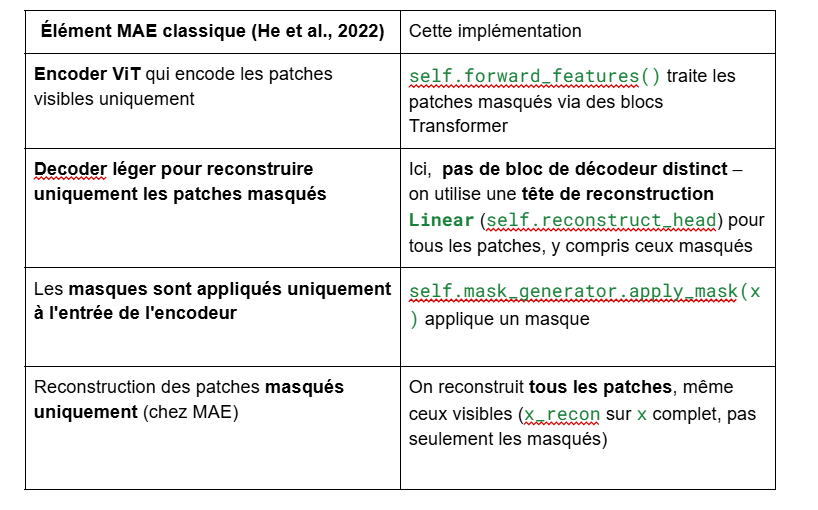

In [ ]:
#Métriques d'évaluation

def compute_mse(pred, target):
    """
    Calcule le Mean Squared Error entre les images prédites et cibles
    pred, target: (batch_size, channels, height, width)
    """
    return F.mse_loss(pred, target).item()

def compute_ssim(pred, target):
    """
    Calcule le Structural Similarity Index entre les images prédites et cibles
    pred, target: (batch_size, channels, height, width)
    """
    # Normaliser les images pour SSIM (doit être entre 0 et 1)
    pred_norm = (pred - pred.min()) / (pred.max() - pred.min() + 1e-8)
    target_norm = (target - target.min()) / (target.max() - target.min() + 1e-8)

    # Calculer SSIM
    ssim_val = ssim(pred_norm, target_norm, data_range=1.0, size_average=True)
    return ssim_val.item()

In [ ]:
# Définir la fonction de perte
def reconstruction_loss(pred, target, mask=None):
    """
    Calcule la perte de reconstruction en ne considérant que les patches masqués
     Args:
        pred (torch.Tensor): Image prédite de forme (batch_size, channels, height, width)
        target (torch.Tensor): Image cible de forme (batch_size, channels, height, width)
        mask (torch.Tensor, optional): Masque booléen de forme (batch_size, num_patches)
                                     indiquant les patches visibles (True) ou masqués (False)

    Returns:
        torch.Tensor: Valeur scalaire de la perte MSE (Mean Squared Error)
    """
    if mask is None:
        # Si pas de masque spécifié, calcule la perte sur l'image entière
        return F.mse_loss(pred, target)

    # Pour simplifier, calculons la perte sur toute l'image
    return F.mse_loss(pred, target)

In [ ]:
# Préparation des données pour Oxford 102 Flowers
def get_oxford102_dataset():
    """
    Prépare le dataset Oxford 102 Flowers pour l'entraînement et la validation.
    Ce dataset contient 102 catégories différentes de fleurs, chacune avec 40 à 258 images.

    Returns:
        tuple: (train_loader, valid_loader)
            - train_loader: DataLoader pour l'entraînement
            - valid_loader: DataLoader pour la validation
    """
    # Définir les transformations pour les images
    transform = transforms.Compose([
        # Redimensionne toutes les images à la taille fixe IMAGE_SIZE x IMAGE_SIZE
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        # Convertit l'image PIL en tensor PyTorch avec valeurs entre [0, 1]
        transforms.ToTensor(),
        # Normalise avec les moyennes et écarts-types standards d'ImageNet
        # Cette normalisation aide à stabiliser l'entraînement car les valeurs sont centrées
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Télécharger et charger le dataset complet

    # Charger tous les splits
    train_split = Flowers102(root='data', split='train', transform=transform, download=True)
    val_split = Flowers102(root='data', split='val', transform=transform, download=True)
    test_split = Flowers102(root='data', split='test', transform=transform, download=True)

    # Combiner tous les splits
    full_dataset = torch.utils.data.ConcatDataset([train_split, val_split, test_split])


    # Vérifier la taille du dataset
    dataset_size = len(full_dataset)
    print(f"Dataset Oxford 102 Flowers - Nombre total d'images: {dataset_size}")

    # Calcul des tailles des splits pour l'entraînement et la validation
    # TRAIN_SPLIT est une constante globale définissant la proportion pour l'entraînement
    train_size = int(TRAIN_SPLIT * dataset_size)
    valid_size = dataset_size - train_size

    # Diviser le dataset de manière reproductible
    train_dataset, valid_dataset = random_split(
        full_dataset,
        [train_size, valid_size],
        generator=torch.Generator().manual_seed(42)  # Seed fixe pour reproductibilité
    )

    print(f"Split d'entraînement: {train_size} images")
    print(f"Split de validation: {valid_size} images")

    # Créer les dataloaders pour l'entraînement
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,  # Taille du batch définie globalement
        shuffle=True,  # Mélange les données à chaque époque pour l'entraînement
        num_workers=4,  # Utilise 4 processus pour charger les données en parallèle
        pin_memory=True if torch.cuda.is_available() else False  # Optimisation pour GPU
    )

    # Créer les dataloaders pour la validation
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,  # Pas besoin de mélanger pour la validation
        num_workers=4,
        pin_memory=True if torch.cuda.is_available() else False
    )

    return train_loader, valid_loader

## Pourquoi les dataloaders?
Les DataLoaders permettent de charger les données par lots (batches) au lieu de charger l'ensemble du dataset en mémoire:

* Il ne charge qu'un batch à la fois en mémoire
* Il libère automatiquement la mémoire des batches précédents
* Le transfert vers le GPU est optimisé (pin_memory)
* Le préchargement se fait en parallèle (num_workers=4)

In [ ]:
# Fonction d'entraînement
def train(model, trainloader, optimizer):
    """
    Effectue une époque d'entraînement complète sur le modèle de reconstruction d'images masquées.

    Args:
        model (nn.Module): Le modèle Vision Transformer à entraîner
        trainloader (DataLoader): DataLoader contenant les données d'entraînement
        optimizer (torch.optim.Optimizer): Optimiseur pour mettre à jour les poids du modèle

    Returns:
        tuple: (avg_loss, avg_mse, avg_ssim)
            - avg_loss: Perte moyenne de reconstruction sur l'époque
            - avg_mse: MSE moyen entre les images reconstruites et originales
            - avg_ssim: SSIM moyen (similarité structurelle) entre les images
    """
    # Passe le modèle en mode entraînement
    model.train()

    # Initialise les accumulateurs de métriques
    train_loss = 0.0
    train_mse = 0.0
    train_ssim = 0.0
    batch_count = 0

    # Boucle sur tous les batches du dataset d'entraînement
    for batch_idx, (images, _) in enumerate(trainloader):
        # Déplace les images sur le bon dispositif (GPU/CPU)
        images = images.to(DEVICE)

        # Réinitialise les gradients pour éviter leur accumulation
        optimizer.zero_grad()

        # Forward pass : obtient l'image reconstruite et le masque
        reconstructed, original, mask = model(images)

        # Calcul de la perte de reconstruction (MSE sur toute l'image)
        loss = reconstruction_loss(reconstructed, images, mask)

        # Backward pass : calcule les gradients
        loss.backward()

        # Mise à jour des poids du modèle
        optimizer.step()

        # Calcul des métriques supplémentaires pour évaluation
        batch_mse = compute_mse(reconstructed, images)
        batch_ssim = compute_ssim(reconstructed, images)

        # Accumulation des métriques pour la moyenne finale
        train_loss += loss.item()
        train_mse += batch_mse
        train_ssim += batch_ssim
        batch_count += 1

        # Affiche les progrès tous les 20 batches
        if (batch_idx + 1) % 20 == 0:
            print(f'Batch: {batch_idx + 1}/{len(trainloader)}, Loss: {loss.item():.4f}, MSE: {batch_mse:.4f}, SSIM: {batch_ssim:.4f}')

    # Calcul des moyennes des métriques sur l'époque complète
    avg_loss = train_loss / batch_count
    avg_mse = train_mse / batch_count
    avg_ssim = train_ssim / batch_count

    return avg_loss, avg_mse, avg_ssim

In [ ]:
# Fonction d'évaluation
def evaluate(model, testloader):
    model.eval()
    test_loss = 0.0
    test_mse = 0.0
    test_ssim = 0.0
    batch_count = 0

    with torch.no_grad():
        for batch_idx, (images, _) in enumerate(testloader):
            images = images.to(DEVICE)

            # Forward pass
            reconstructed, original, mask = model(images)

            # Calcul de la perte
            loss = reconstruction_loss(reconstructed, images, mask)

            # Calcul des métriques
            batch_mse = compute_mse(reconstructed, images)
            batch_ssim = compute_ssim(reconstructed, images)

            test_loss += loss.item()
            test_mse += batch_mse
            test_ssim += batch_ssim
            batch_count += 1

    avg_loss = test_loss / batch_count
    avg_mse = test_mse / batch_count
    avg_ssim = test_ssim / batch_count

    return avg_loss, avg_mse, avg_ssim

In [ ]:

# Fonction pour visualiser les résultats
def visualize_results(model, testloader, num_examples=5):
    model.eval()

    # Prendre quelques exemples du set de test
    dataiter = iter(testloader)
    images, _ = next(dataiter)
    images = images[:num_examples].to(DEVICE)

    with torch.no_grad():
        # Obtenir les prédictions
        reconstructed, original, mask = model(images)

        # Calculer MSE et SSIM pour chaque image
        mse_values = []
        ssim_values = []

        for i in range(num_examples):
            # Calculer MSE pour cette image
            img_mse = F.mse_loss(reconstructed[i], images[i]).item()
            mse_values.append(img_mse)

            # Calculer SSIM pour cette image
            img_pred = (reconstructed[i] - reconstructed[i].min()) / (reconstructed[i].max() - reconstructed[i].min() + 1e-8)
            img_target = (images[i] - images[i].min()) / (images[i].max() - images[i].min() + 1e-8)
            img_ssim = ssim(img_pred.unsqueeze(0), img_target.unsqueeze(0), data_range=1.0, size_average=True).item()
            ssim_values.append(img_ssim)

        # Visualiser les résultats
        fig, axes = plt.subplots(num_examples, 3, figsize=(15, 5 * num_examples))

        for i in range(num_examples):
            # Image originale
            img_orig = images[i].cpu().numpy()
            img_orig = np.transpose(img_orig, (1, 2, 0))
            # Dénormalisation pour ImageNet
            img_orig = img_orig * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img_orig = np.clip(img_orig, 0, 1)

            axes[i, 0].imshow(img_orig)
            axes[i, 0].set_title('Original')
            axes[i, 0].axis('off')

            # Image masquée (recréée en appliquant le masque à l'original)
            p = PATCH_SIZE
            grid_size = IMAGE_SIZE // p
            img_masked = img_orig.copy()

            # Remodeler le masque pour correspondre à la grille de patches
            mask_reshaped = mask[i].reshape(grid_size, grid_size).cpu().numpy()

            # Appliquer le masque visuellement (avec des zones grisées)
            for h in range(grid_size):
                for w in range(grid_size):
                    if not mask_reshaped[h, w]:
                        # Si le patch est masqué, le griser
                        img_masked[h*p:(h+1)*p, w*p:(w+1)*p, :] = 0.5

            axes[i, 1].imshow(img_masked)
            axes[i, 1].set_title('Masqué')
            axes[i, 1].axis('off')

            # Image reconstruite
            img_recon = reconstructed[i].cpu().numpy()
            img_recon = np.transpose(img_recon, (1, 2, 0))
            # Dénormalisation pour ImageNet
            img_recon = img_recon * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img_recon = np.clip(img_recon, 0, 1)

            axes[i, 2].imshow(img_recon)
            axes[i, 2].set_title(f'Reconstruit\nMSE: {mse_values[i]:.4f}, SSIM: {ssim_values[i]:.4f}')
            axes[i, 2].axis('off')

        plt.tight_layout()
        plt.savefig('reconstruction_oxford102_with_metrics.png')
        plt.show()

##Fonction principale


Utilisation du device: cpu
Chargement du dataset Oxford 102 Flowers...


100%|██████████| 345M/345M [00:14<00:00, 23.7MB/s]
100%|██████████| 502/502 [00:00<00:00, 640kB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 14.5MB/s]


Dataset Oxford 102 Flowers - Nombre total d'images: 8189
Split d'entraînement: 6551 images
Split de validation: 1638 images
Initialisation du modèle...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Nombre total de paramètres: 11,263,104

Entraînement avec masquage aléatoire et évaluation MSE/SSIM:

Epoch 1/6
Batch: 20/205, Loss: 0.7327, MSE: 0.7327, SSIM: 0.1804
Batch: 40/205, Loss: 0.5806, MSE: 0.5806, SSIM: 0.2835
Batch: 60/205, Loss: 0.6057, MSE: 0.6057, SSIM: 0.3067
Batch: 80/205, Loss: 0.5833, MSE: 0.5833, SSIM: 0.3028
Batch: 100/205, Loss: 0.5679, MSE: 0.5679, SSIM: 0.3240
Batch: 120/205, Loss: 0.5290, MSE: 0.5290, SSIM: 0.3337
Batch: 140/205, Loss: 0.5306, MSE: 0.5306, SSIM: 0.3366
Batch: 160/205, Loss: 0.4362, MSE: 0.4362, SSIM: 0.3520
Batch: 180/205, Loss: 0.4506, MSE: 0.4506, SSIM: 0.3839
Batch: 200/205, Loss: 0.5705, MSE: 0.5705, SSIM: 0.3664
Epoch 1/6, Train Loss: 0.6192, MSE: 0.6192, SSIM: 0.3015
Epoch 1/6, Valid Loss: 0.5271, MSE: 0.5271, SSIM: 0.3569

Epoch 2/6
Batch: 20/205, Loss: 0.5400, MSE: 0.5400, SSIM: 0.3494
Batch: 40/205, Loss: 0.4818, MSE: 0.4818, SSIM: 0.3770
Batch: 60/205, Loss: 0.5073, MSE: 0.5073, SSIM: 0.3936
Batch: 80/205, Loss: 0.4885, MSE: 0.4885, 

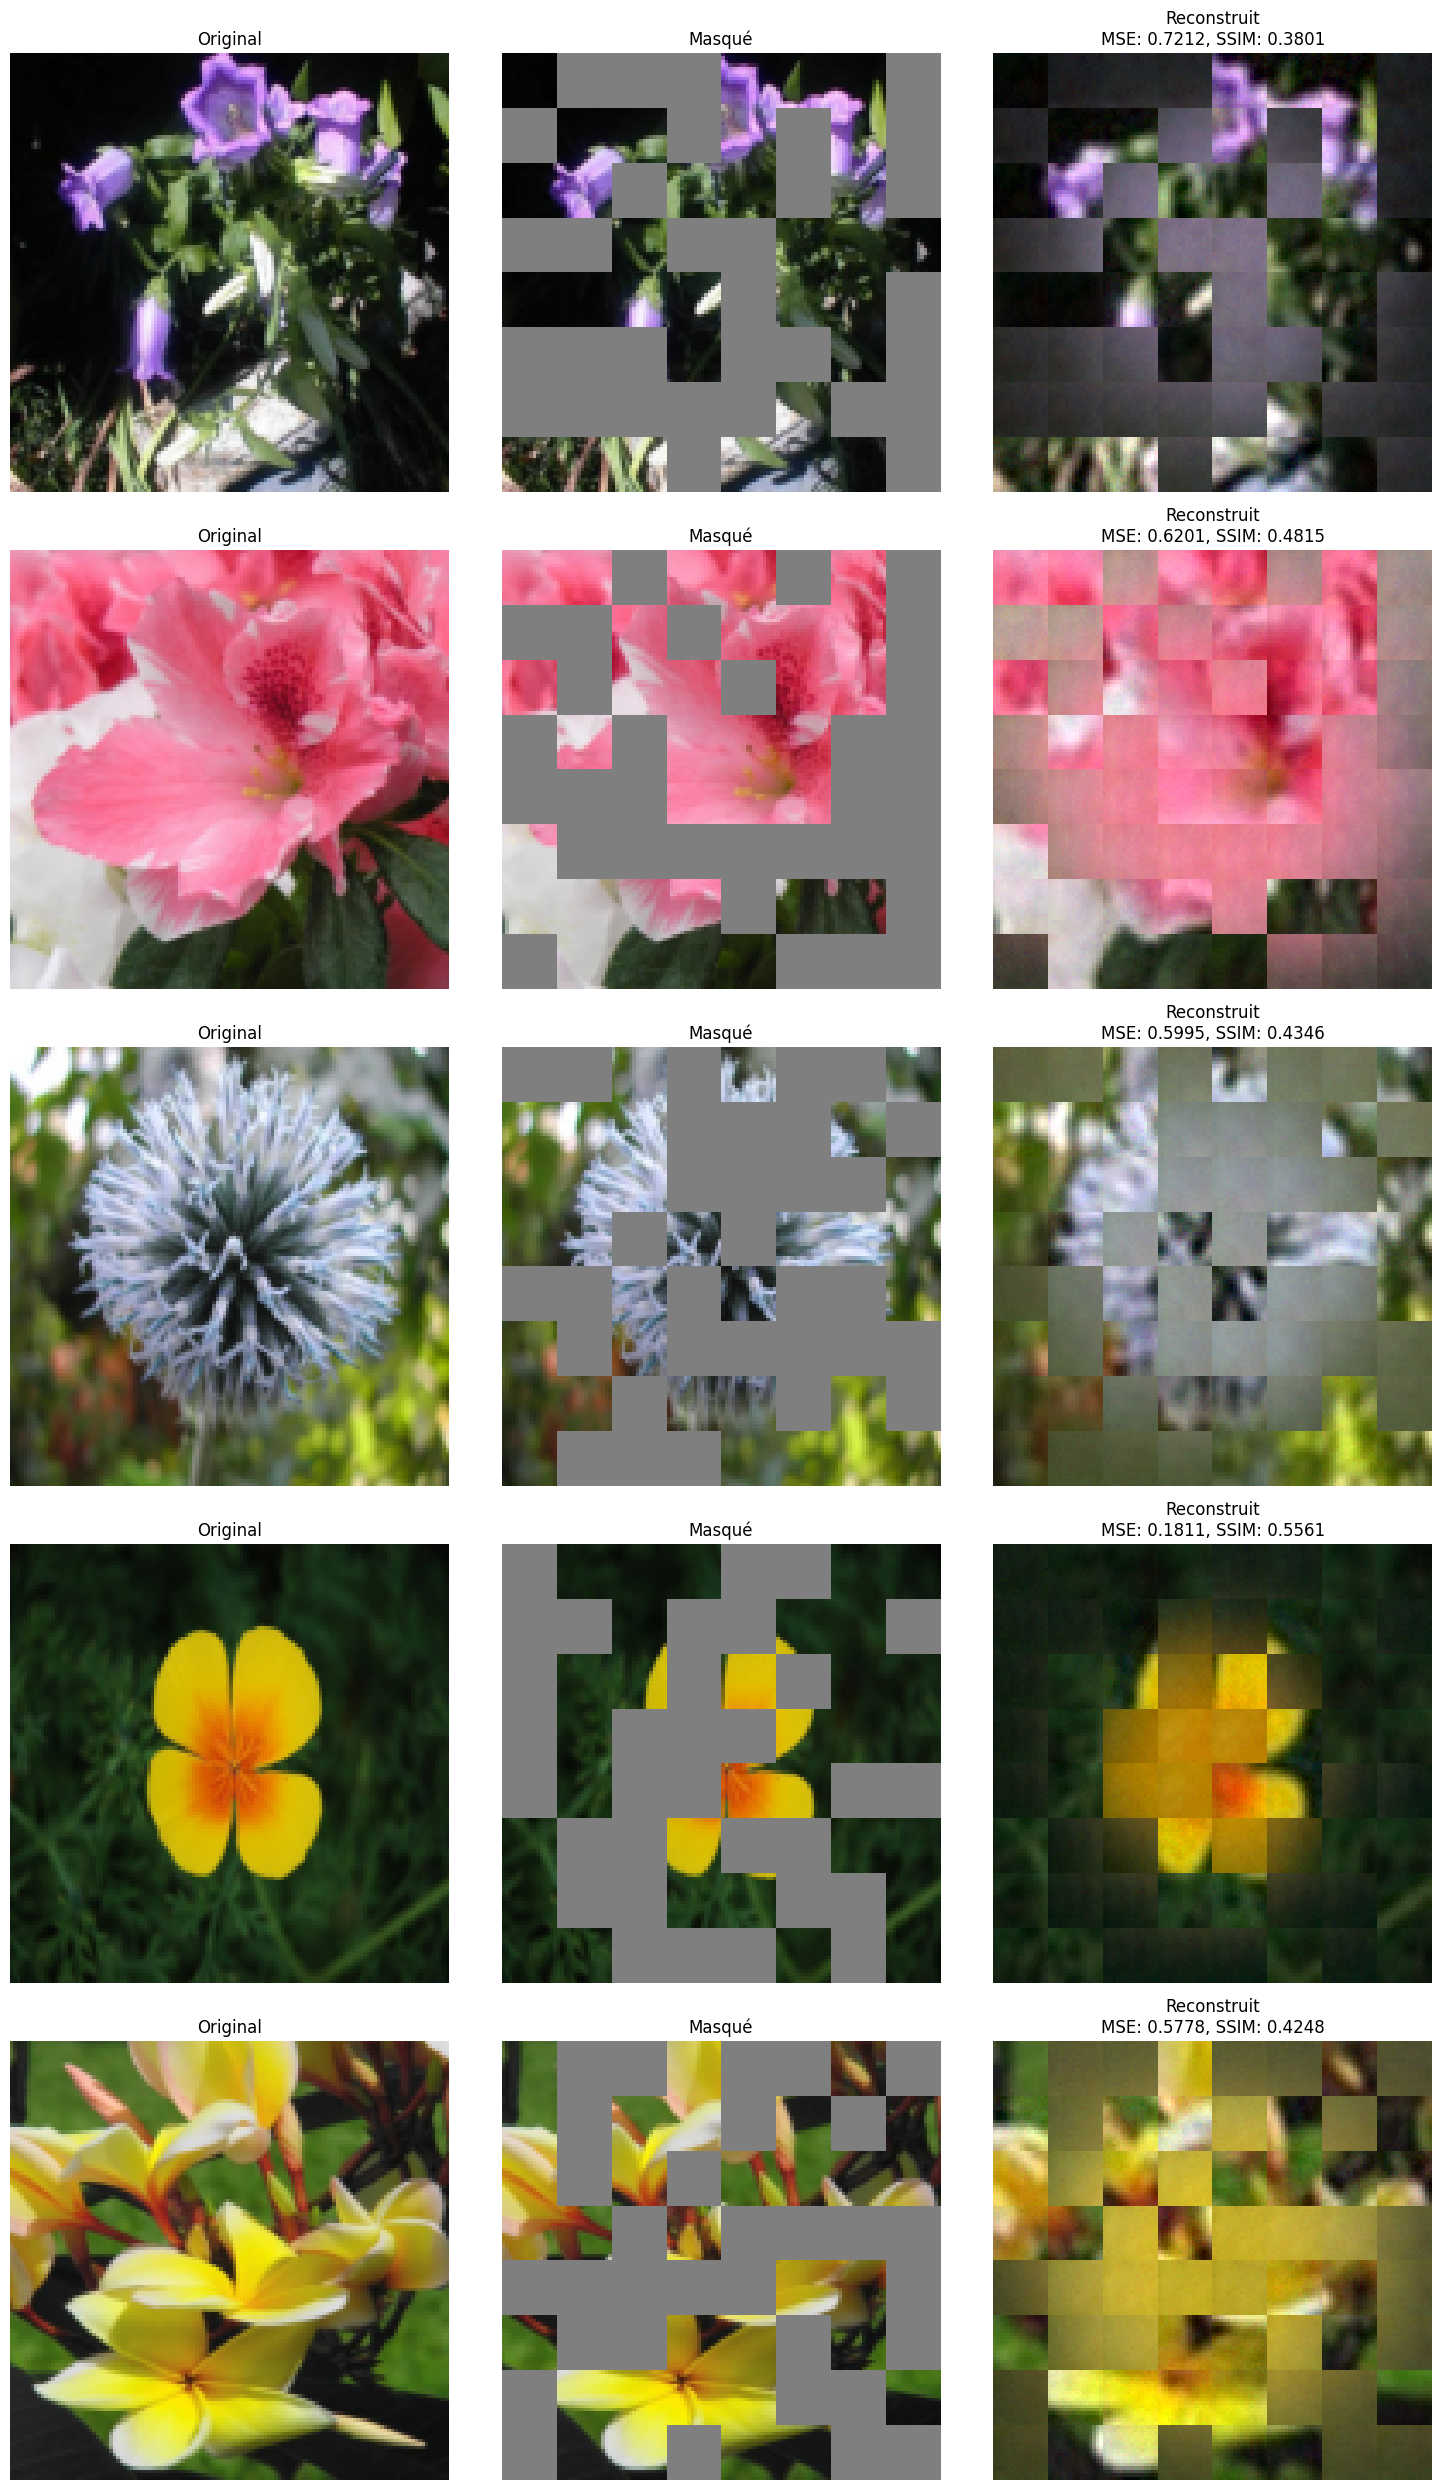

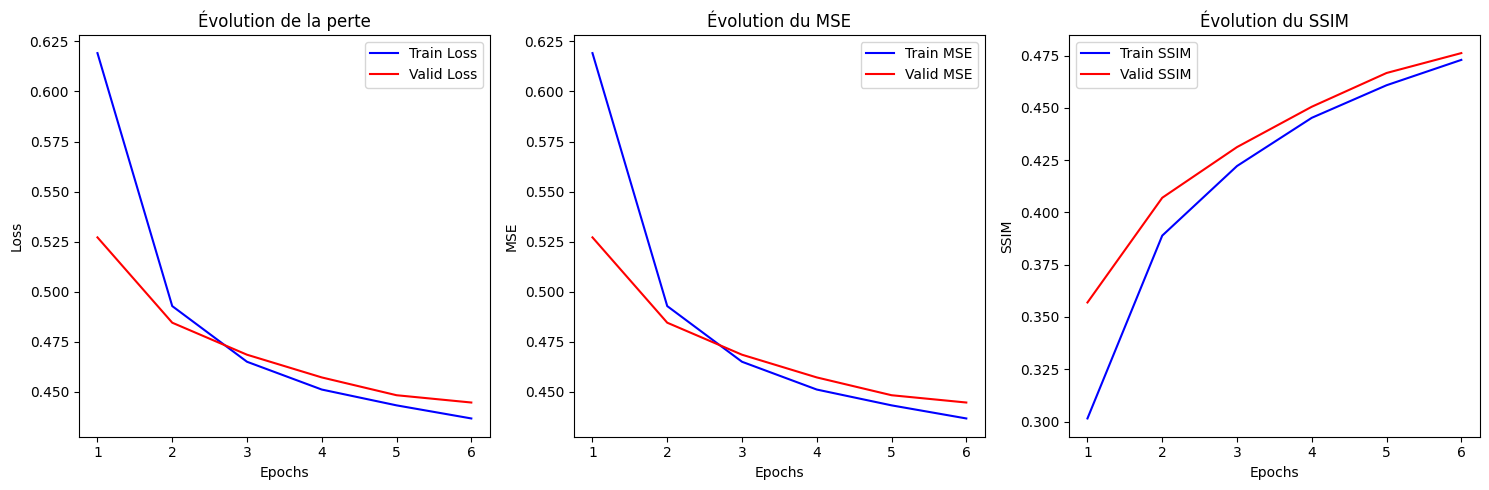


Résumé des métriques finales:
Train - Loss: 0.4367, MSE: 0.4367, SSIM: 0.4730
Valid - Loss: 0.4446, MSE: 0.4446, SSIM: 0.4763


In [ ]:
# Fonction principale
def main():
    """
    Fonction principale orchestrant l'entraînement complet du modèle Vision Transformer
    pour la reconstruction d'images masquées sur le dataset Oxford 102 Flowers.
    """
    print(f"Utilisation du device: {DEVICE}")

    # Phase 1: Préparation des données
    print("Chargement du dataset Oxford 102 Flowers...")
    trainloader, validloader = get_oxford102_dataset()

    # Phase 2: Initialisation du modèle
    print("Initialisation du modèle...")
    model = MaskedImageViT(
        image_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        in_channels=3,
        embed_dim=EMBED_DIM,
        num_heads=NUM_HEADS,
        num_layers=NUM_LAYERS,
        mlp_ratio=MLP_RATIO
    ).to(DEVICE)

    # Afficher des informations sur la taille du modèle
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Nombre total de paramètres: {total_params:,}")

    # Initialisation de l'optimiseur AdamW avec le learning rate spécifié
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

    print("\nEntraînement avec masquage aléatoire et évaluation MSE/SSIM:")

    # Phase 3: Entraînement et évaluation
    # Listes pour stocker les métriques à chaque époque
    train_losses = []  # Perte d'entraînement
    train_mses = []    # MSE d'entraînement
    train_ssims = []   # SSIM d'entraînement
    valid_losses = []  # Perte de validation
    valid_mses = []    # MSE de validation
    valid_ssims = []   # SSIM de validation

    # Boucle d'entraînement sur toutes les époques
    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")

        # Entraînement sur une époque
        train_loss, train_mse, train_ssim = train(model, trainloader, optimizer)
        train_losses.append(train_loss)
        train_mses.append(train_mse)
        train_ssims.append(train_ssim)

        # Évaluation sur l'ensemble de validation
        valid_loss, valid_mse, valid_ssim = evaluate(model, validloader)
        valid_losses.append(valid_loss)
        valid_mses.append(valid_mse)
        valid_ssims.append(valid_ssim)

        # Affichage des métriques de validation pour cette époque
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {train_loss:.4f}, MSE: {train_mse:.4f}, SSIM: {train_ssim:.4f}")

        print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Valid Loss: {valid_loss:.4f}, MSE: {valid_mse:.4f}, SSIM: {valid_ssim:.4f}")

    # Phase 4: Visualisation des résultats
    # Visualisation des reconstructions d'images
    visualize_results(model, validloader)

    # Création des graphiques pour les métriques
    plt.figure(figsize=(15, 5))

    # Graphique 1: Évolution de la perte
    plt.subplot(1, 3, 1)
    plt.plot(range(1, NUM_EPOCHS+1), train_losses, 'b', label='Train Loss')
    plt.plot(range(1, NUM_EPOCHS+1), valid_losses, 'r', label='Valid Loss')
    plt.title('Évolution de la perte')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Graphique 2: Évolution du MSE
    plt.subplot(1, 3, 2)
    plt.plot(range(1, NUM_EPOCHS+1), train_mses, 'b', label='Train MSE')
    plt.plot(range(1, NUM_EPOCHS+1), valid_mses, 'r', label='Valid MSE')
    plt.title('Évolution du MSE')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()

    # Graphique 3: Évolution du SSIM
    plt.subplot(1, 3, 3)
    plt.plot(range(1, NUM_EPOCHS+1), train_ssims, 'b', label='Train SSIM')
    plt.plot(range(1, NUM_EPOCHS+1), valid_ssims, 'r', label='Valid SSIM')
    plt.title('Évolution du SSIM')
    plt.xlabel('Epochs')
    plt.ylabel('SSIM')
    plt.legend()

    plt.tight_layout()
    plt.savefig('metrics_oxford102.png')  # Sauvegarde les graphiques
    plt.show()

    # Phase 5: Sauvegarde du modèle entraîné
    torch.save(model.state_dict(), 'vit_reconstruction_oxford102_with_metrics.pth')

    # Affichage du résumé final des performances
    print("\nRésumé des métriques finales:")
    print(f"Train - Loss: {train_losses[-1]:.4f}, MSE: {train_mses[-1]:.4f}, SSIM: {train_ssims[-1]:.4f}")
    print(f"Valid - Loss: {valid_losses[-1]:.4f}, MSE: {valid_mses[-1]:.4f}, SSIM: {valid_ssims[-1]:.4f}")

# Point d'entrée du script
if __name__ == "__main__":
    main()

Training en masquant 20% des patchs et sur 10 époques

In [ ]:
MASK_RATIO = 0.2
NUM_EPOCHS = 10


Utilisation du device: cpu
Chargement du dataset Oxford 102 Flowers...
Dataset Oxford 102 Flowers - Nombre total d'images: 8189
Split d'entraînement: 6551 images
Split de validation: 1638 images
Initialisation du modèle...
Nombre total de paramètres: 11,263,104

Entraînement avec masquage aléatoire et évaluation MSE/SSIM:

Epoch 1/10
Batch: 20/205, Loss: 0.7334, MSE: 0.7334, SSIM: 0.1786
Batch: 40/205, Loss: 0.6021, MSE: 0.6021, SSIM: 0.2716
Batch: 60/205, Loss: 0.5778, MSE: 0.5778, SSIM: 0.2799
Batch: 80/205, Loss: 0.5953, MSE: 0.5953, SSIM: 0.3301
Batch: 100/205, Loss: 0.6071, MSE: 0.6071, SSIM: 0.3010
Batch: 120/205, Loss: 0.5381, MSE: 0.5381, SSIM: 0.3096
Batch: 140/205, Loss: 0.4762, MSE: 0.4762, SSIM: 0.3763
Batch: 160/205, Loss: 0.5986, MSE: 0.5986, SSIM: 0.3478
Batch: 180/205, Loss: 0.5348, MSE: 0.5348, SSIM: 0.3566
Batch: 200/205, Loss: 0.5750, MSE: 0.5750, SSIM: 0.3541
Epoch 1/10, Train Loss: 0.6211, MSE: 0.6211, SSIM: 0.2998
Epoch 1/10, Valid Loss: 0.5315, MSE: 0.5315, SSIM:

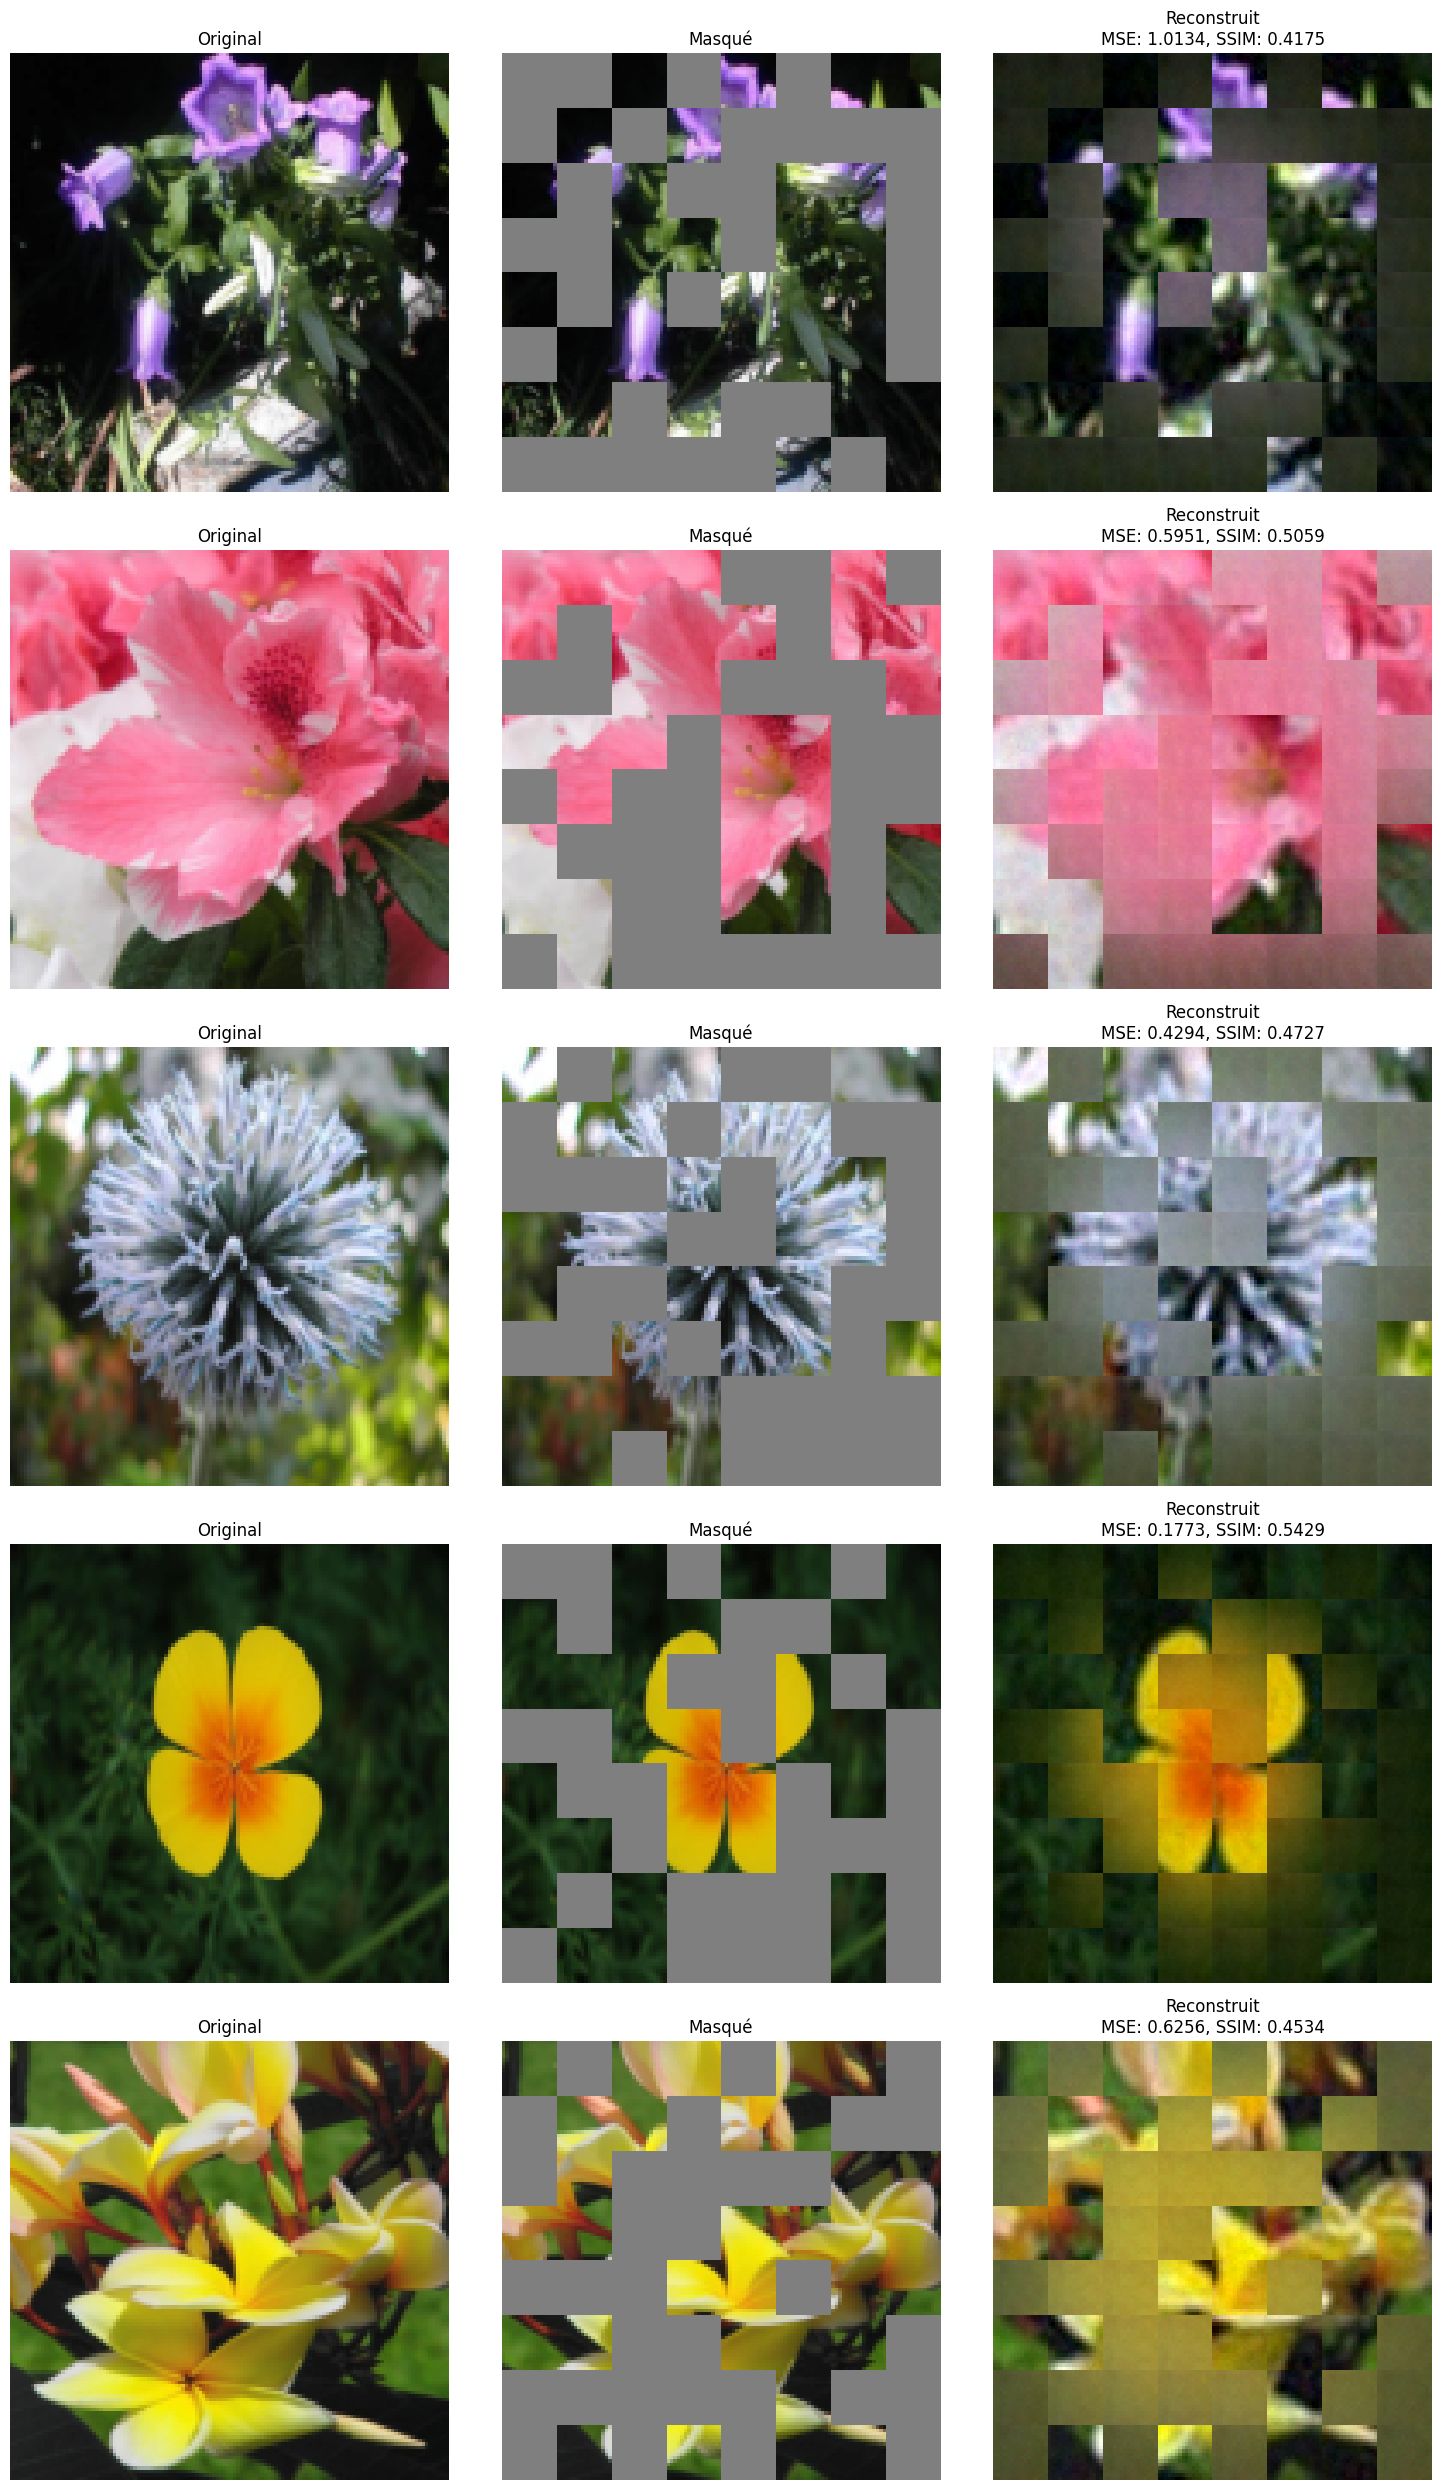

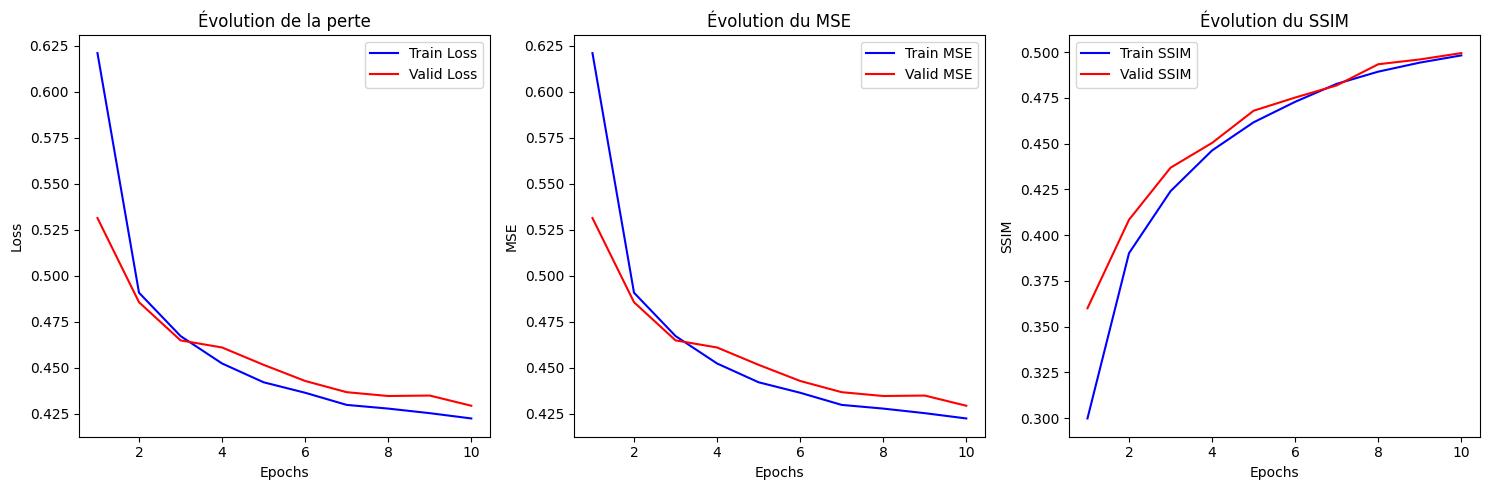


Résumé des métriques finales:
Train - Loss: 0.4226, MSE: 0.4226, SSIM: 0.4982
Valid - Loss: 0.4295, MSE: 0.4295, SSIM: 0.4995


In [ ]:
# Point d'entrée du script
if __name__ == "__main__":
    main()